In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Define Global Functions for Preprocessing

In [36]:

def create_class(df):
    # create Class attribute with np.select
    conditions = [df['NORMCOG']==1, (df['NORMCOG']==0) & (df['DEMENTED']==0), df['DEMENTED']==1]
    choices = [0,1,2] # 0 Normal Cog, 1 MCI, 2 Dementia
    df['Class'] = np.select(conditions, choices)

# Data contains binary attributes: NORMCOG and DEMENTED 
# will need to transform into 3 features where MCI is when NORMCOG and DEMENTED are both 0 (No)
def plot_class_bal(df):
    label_count = df['Class'].value_counts()
    # define parameters
    labels = ['Normal Cognition', 'MCI', 'Dementia']
    sizes = [label_count[0], label_count[1], label_count[2]]
    # assemble piechart
    plt.pie(sizes, labels=labels, startangle=400, colors=['darkseagreen', 'lightskyblue', 'dodgerblue'], autopct='%1.1f%%')
    plt.show()


def replace_with_na(df, column, list_to_replace):
    df[column] = df[column].where(~df[column].isin(list_to_replace), np.nan)

# create date column
def create_date_col(df):
    df['DATE'] = pd.to_datetime(
        df['VISITYR'].astype(str) + '-' +
        df['VISITMO'].astype(str).str.zfill(2) + '-' +
        df['VISITDAY'].astype(str).str.zfill(2)
        )
    return df


# create delta col: for choosing smallest interval between dates
def create_delta_col(df, datecolumn):
    # dynamically name column
    new_col_name = f'delta_{datecolumn}'

    # filter to not NA
    non_na = df[datecolumn].notna()

    # calc abs value of delta
    df[new_col_name] = abs(df.loc[non_na, 'NACCDT'] - df.loc[non_na, datecolumn]) # NACC date - scan date
    
    return df

# Create col rule to show smallest delta per pt
# because some participants have values for both MRI date and SCAN date
def rule_condition(row):
    if pd.isna(row['delta_SCANDT']) and pd.isna(row['delta_MRIDT']): # if both NA
        return np.nan # return NA
    elif pd.isna(row['delta_SCANDT']): # if only MRIDT present
        return 'MRIDT'
    elif pd.isna(row['delta_MRIDT']): # if only SCANDT present
        return 'SCANDT'
    else: 
        return 'SCANDT' if (row['delta_SCANDT']) < (row['delta_MRIDT']) else 'MRIDT' # if SCAN delta smaller return SCANDT



# 1st: just NACC data

## Preprocessing

In [3]:
# read in data
# low_memory=False reads entire file into memory before inferring data types = consistent data types per column
# for basic understanding of the data, use default low_memory=True
# total records is 192,088 & 1,024 attributes
# runs, but it takes a long time

nacc = pd.read_csv("/Users/sarahbinder/Desktop/NACC Data/investigator_nacc66.csv", low_memory=False) 
nacc.head()

# count unique IDs
# nacc contains longitudinal data, but for this project want to use each NACCID only once
nacc['NACCID'].nunique()

51836

In [4]:
# select first row per NACCID
nacc_first = nacc.groupby('NACCID',as_index=False).first()

/var/folders/c7/mq5f_1092xqfr4yszbk6f7gh0000gn/T/ipykernel_8840/1106396660.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nacc_first = nacc.groupby('NACCID',as_index=False).first()


In [5]:
# create Class attribute with np.select
create_class(nacc_first)
class_df = nacc_first.loc[:, ['NACCID', 'Class']]

In [6]:
# read in csv with selected columns
Select_Columns = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/Columns/Select_Columns.csv',index_col=0)

# select columns in nacc_first that are present in select columns df
df = nacc_first[Select_Columns.columns]

In [7]:
# left join to add class label
nacc_df = df.merge(class_df, on='NACCID', how='left')
nacc_df.shape

(51836, 280)

In [8]:
# feature transformation

def feature_transform(df):

    # 1) convert missing codes to NA
    df = df.copy() 
    
    #remove whitespace that will affect string operations
    df.columns = df.columns.str.strip()

    # tag column names with 'cog' for cognitive measure columns
    df.columns.values[47:180] = [col + '_cog' for col in df.columns[47:180]]

    # define lists used in for loop
    cog_values_na = [88,95,96,97,98,995,996,997,998,-4]      # these values signal 'unknown', 'not available' or similar codes in NACC data dictionary
    missing_codes = [8,88,88.8,888,888.8,8888,777,-4,-4.4,9,99,999,9999]

    # loop to recode certain values as NA
    for column in df.columns:
        # can't have '88' changed to 'NA' in 'Age' column:
        if column == 'NACCAGE':
            pass #no action
        elif column.endswith('_cog'):
            # apply NA changes 
            replace_with_na(df,column,cog_values_na)
        else:
             # apply NA changes 
            replace_with_na(df,column,missing_codes)

    # 2) Feature transformation

    subset_faq = df.iloc[:,33:43]
    subset_med = df.iloc[:,186:226]
    subset_cvd = df.iloc[:,227:244]
    subset_psych = df.iloc[:,266:279]
    subset_neuro = df.iloc[:,244:266]

    # Create new cols
    new_columns = pd.DataFrame({
    'faq_tot': subset_faq.sum(axis=1), # sum of FAQ responses
    'chronic_cond': np.where(subset_med.eq(1).any(axis=1), 1, 0), # 1 if any show a value of 1
    'cvd_cond': np.where(subset_cvd.eq(1).any(axis=1), 1, 0),
    'neuro_injury': np.where(subset_neuro.eq(1).any(axis=1), 1, 0),
    'psych_cond': np.where(subset_psych.eq(1).any(axis=1), 1, 0)
    }, index=df.index)

    # Concat new columns to original df all at once
    df = pd.concat([df, new_columns], axis=1)

    # 3) Drop categorical data, including NACCID
    
    categorical = list(df.select_dtypes(exclude=[np.number]).columns)        
    df.drop(categorical, axis=1, inplace=True)

    return df

In [9]:
df = feature_transform(nacc_df)
df = df.copy()  # This creates a defragmented copy
df = df.reset_index(drop=True)
df

,BIRTHYR,SEX,HISPANIC,RACE,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,...,ANXIETY,OCD,NPSYDEV,PSYCDIS,Class,faq_tot,chronic_cond,cvd_cond,neuro_injury,psych_cond
0,1944,2,0.0,1.0,1.0,16.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,0.0,1,0.0,0,0,0,0
1,1935,2,0.0,1.0,1.0,15.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1,0.0,1,0,0,0
2,1952,1,0.0,1.0,1.0,18.0,1.0,2.0,2.0,1.0,...,NaN,NaN,NaN,1.0,1,8.0,1,0,1,1
3,1971,2,0.0,1.0,1.0,18.0,1.0,2.0,1.0,1.0,...,NaN,0.0,1.0,0.0,0,0.0,1,0,0,1
4,1926,1,0.0,1.0,1.0,16.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,1.0,2,21.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51831,1926,2,0.0,1.0,NaN,20.0,1.0,2.0,1.0,2.0,...,NaN,NaN,NaN,0.0,0,1.0,1,1,0,0
51832,1935,2,0.0,2.0,1.0,14.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,0.0,1,0.0,1,0,0,0
51833,1950,1,0.0,1.0,1.0,12.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,2.0,0,0.0,1,0,0,1
51834,1935,2,0.0,2.0,1.0,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1.0,2,5.0,1,0,0,1


# Class Balance Visual

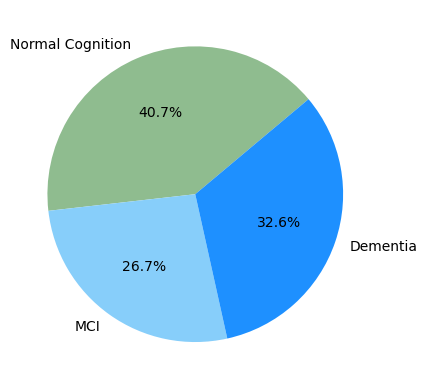

In [29]:
 # visualize class distribution
plot_class_bal(df)

# Split

In [11]:
# 1) split data into train and test, inputs and output

import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1) # drop class
y = df['Class']  # select class (target) variable only

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=303, stratify=y, )


In [12]:
# ensure proportional distribution 
y_train.value_counts() 
y_test.value_counts() 


Class
0    7171
2    5752
1    4702
Name: count, dtype: int64

# Define Evaluate Function

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

def evaluate(model, X_test=X_test, y_test=y_test):
    
    # define variables
    y_pred = model.predict(X_test) # run model on test data
    y_pred_prob = model.predict_proba(X_test) # for auc, shows probabilities of positive class
    
    # calculate metrics 
    metrics_dict = {
    'A': round(accuracy_score(y_test, y_pred),3), 
    'auc': round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted'),3), # ovr = one vs rest for multiclass
    'F': round(f1_score(y_test, y_pred, average='weighted'),3),
    'P': round(precision_score(y_test, y_pred, average='weighted'),3),
    'R': round(recall_score(y_test, y_pred, average='weighted'),3) # average='weighted' for multi-class
    }
    return metrics_dict
    

In [14]:
classifiers = {}  # Dictionary to store models. Defined in global scope for use in global output function

# DT

In [15]:
# 2) Build Decision Tree 

from sklearn.tree import DecisionTreeClassifier

# initialize classifer
clf_dec_N = DecisionTreeClassifier(random_state=303) 

# fit model on training data
clf_dec_N.fit(X_train, y_train)

# run evaluate function to run on test data and compute metrics
evaluate(clf_dec_N)

# Model is evaluated when global_output function is run
model_name = 'Decision Tree NACC'
classifiers[model_name] = clf_dec_N

In [16]:
evaluate(clf_dec_N)

{'A': 0.813, 'auc': 0.862, 'F': 0.814, 'P': 0.814, 'R': 0.813}

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


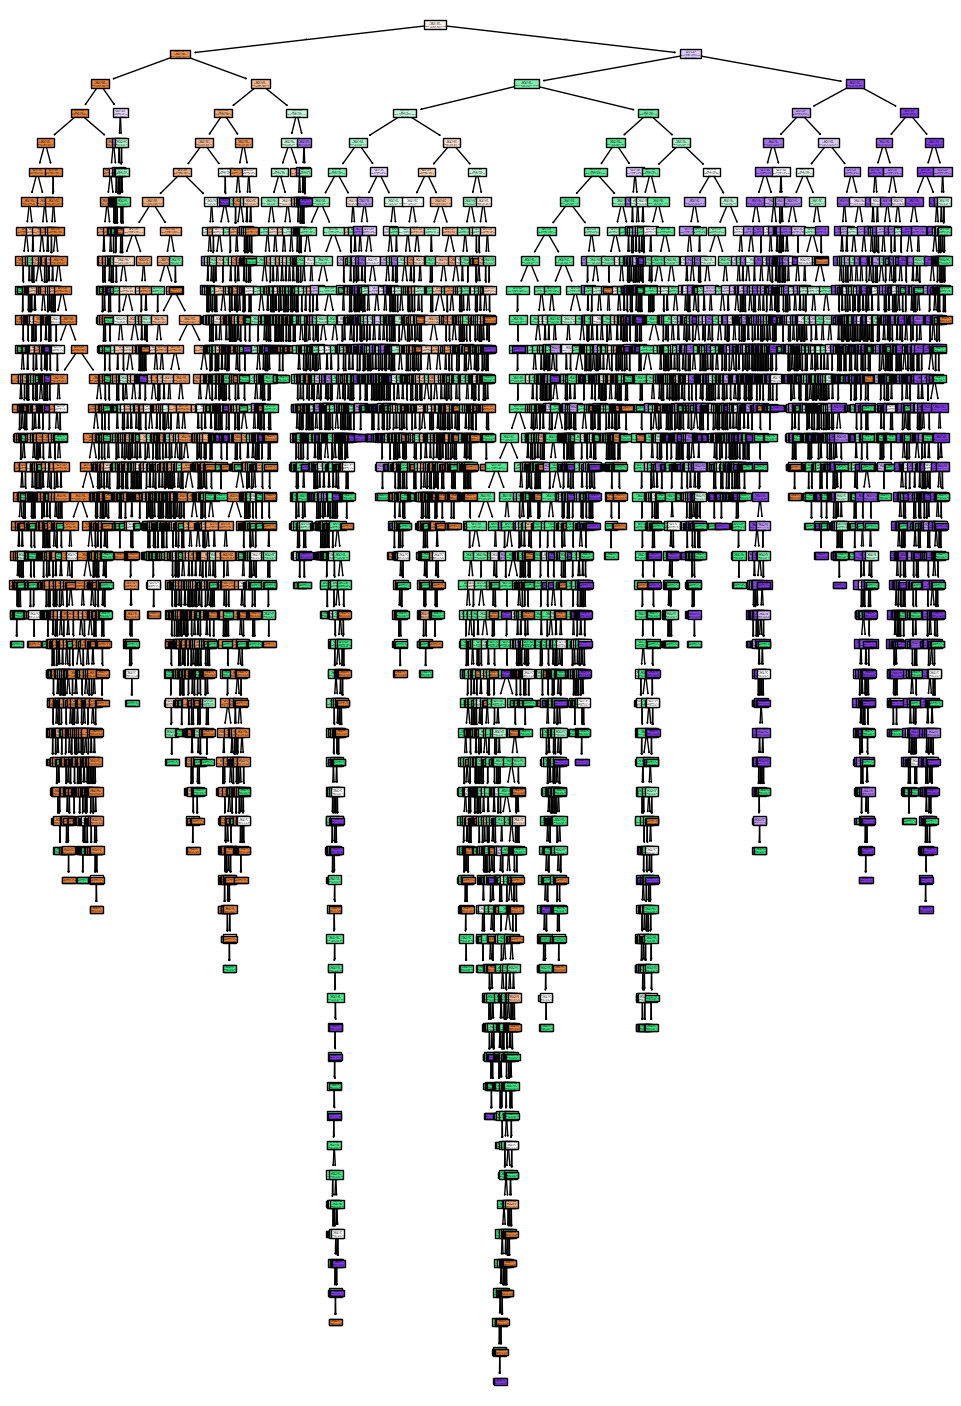

In [132]:
from sklearn import tree

plt.figure(figsize=(12,18))
tree.plot_tree(clf_dec_N, class_names=['normal','MCI','dementia'], filled=True) # filled= True colors nodes by class 
plt.show()

# RF

In [17]:
from sklearn.ensemble import RandomForestClassifier

# iterate over trees
trees = [5, 10, 20]

for t in trees:
    clf_rf = RandomForestClassifier(n_estimators=t, random_state=303) # init 
    clf_rf.fit(X_train, y_train) # fit

    # Model is evaluated when global_output function is run
    model_name = f'Random Forest NACC: {t} trees'
    classifiers[model_name] = clf_rf


In [18]:
# vary number of features

features = [5, 10, 40]  # List of max_features values

for f in features:
    clf_rf = RandomForestClassifier(n_estimators=10, max_features=f, random_state=303) # Init
    clf_rf.fit(X_train, y_train) # Fit
    
    # Model is evaluated when global_output function is run
    model_name = f'Random Forest NACC: {f} features'
    classifiers[model_name] = clf_rf  


# Define Global Output Function

In [19]:
def global_output():

    # initiailize dict
    overall_dict = {}

    # iterate over all models
    for model_name, model in classifiers.items(): # .items for key:value pairs # classifiers is dictionary storing models and metrics
        
        # update dictionary
        overall_dict[model_name] = evaluate(model)

    # see results
    return overall_dict

results_dict = global_output()

In [20]:
results_dict

{'Decision Tree NACC': {'A': 0.813,
  'auc': 0.862,
  'F': 0.814,
  'P': 0.814,
  'R': 0.813},
 'Random Forest NACC: 5 trees': {'A': 0.844,
  'auc': 0.943,
  'F': 0.844,
  'P': 0.844,
  'R': 0.844},
 'Random Forest NACC: 10 trees': {'A': 0.857,
  'auc': 0.956,
  'F': 0.856,
  'P': 0.857,
  'R': 0.857},
 'Random Forest NACC: 20 trees': {'A': 0.861,
  'auc': 0.963,
  'F': 0.861,
  'P': 0.861,
  'R': 0.861},
 'Random Forest NACC: 5 features': {'A': 0.842,
  'auc': 0.949,
  'F': 0.841,
  'P': 0.841,
  'R': 0.842},
 'Random Forest NACC: 10 features': {'A': 0.852,
  'auc': 0.953,
  'F': 0.851,
  'P': 0.852,
  'R': 0.852},
 'Random Forest NACC: 40 features': {'A': 0.86,
  'auc': 0.958,
  'F': 0.86,
  'P': 0.86,
  'R': 0.86}}

# 2nd: Imaging & NACC

# Imaging & NACC Data Preprocessing

## Read in SCAN and non_SCAN MRI datasets

In [26]:
SCAN = pd.read_csv("/Users/sarahbinder/Desktop/NACC Data/investigator_scan_mri_nacc66/investigator_scan_mrisbm_nacc66.csv", low_memory=False)
print(SCAN.shape)
SCAN.head()

(1652, 200)


,NACCID,SCANDT,DESCRIPTION_T1,LONI_IMAGE_T1,DESCRIPTION_FLAIR,LONI_IMAGE_FLAIR,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,...,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH,NACCADC
0,NACC010462,2021-04-27,Accelerated Sagittal IR-FSPGR_(SCAN),10003856,Sagittal 3D FLAIR_(SCAN),10003855,1321.39,494.143,1.568,2.800,...,295,2.459,2.228,5919,6382,2265,2667,2.482,2.295,4032
1,NACC013705,2021-06-29,Accelerated Sagittal IR-FSPGR (SCAN),10005202,Sagittal 3D FLAIR (SCAN),10005201,1240.05,512.965,0.517,2.488,...,365,2.546,2.273,6465,6258,1905,1826,3.134,3.094,4032
2,NACC968063,2021-06-18,Accelerated Sagittal IR-FSPGR (SCAN),10004488,Sagittal 3D FLAIR (SCAN),10004487,1254.70,514.667,0.924,2.821,...,308,2.504,2.575,5615,6030,1838,2037,3.039,2.899,4032
3,NACC968063,2021-05-27,Accelerated Sagittal IR-FSPGR (SCAN),10004073,Sagittal 3D FLAIR (SCAN),10004074,1252.65,519.486,0.964,2.801,...,304,2.641,2.551,5739,6148,1872,2016,2.998,2.940,4032
4,NACC977601,2021-06-02,Accelerated Sagittal IR-FSPGR (SCAN),10004070,Sagittal 3D FLAIR (SCAN),10004071,1155.95,491.082,2.724,2.873,...,306,2.473,2.530,4837,4813,1714,1790,2.846,2.595,4032


In [25]:
non_SCAN = pd.read_csv("/Users/sarahbinder/Desktop/NACC Data/investigator_mri_nacc66.csv", low_memory=False)
print(non_SCAN.shape) #11733, 191

# col that indicates 1 if MRI summary data is available
non_SCAN = non_SCAN[non_SCAN['NACCMVOL'] == 1]

# rename date columns
non_SCAN.rename(columns={
    'MRIYR':'VISITYR',
    'MRIMO':'VISITMO',
    'MRIDY':'VISITDAY'}, inplace=True) #inplace=True to modify original df rather than creating a copy

non_SCAN.iloc[100:120,:]
non_SCAN.shape # 4583, 191

(11733, 191)


(4583, 191)

## Subset NACC data
### Goal: Select one row per NACCID by smallest interval between imaging date and NACC visit date

In [85]:
# Initial Subset

# select subsection (since working with large volume) of each dataset to identify ID and date columns
# create DATE column to merge on in format YYYY-MM-DD

# nacc
nacc_s = create_date_col(nacc.iloc[:,0:7])

#SCAN 
SCAN_s = SCAN.iloc[:,0:5] # already has concatenated date column 'SCANDT'
# convert to datetime 
SCAN_s['SCANDT'] = pd.to_datetime(SCAN_s['SCANDT'])

# non_SCAN
non_SCAN_s = create_date_col(non_SCAN.iloc[:,0:5])


In [86]:
print(nacc_s.shape)
print(SCAN_s.shape)
print(non_SCAN_s.shape)

(192088, 8)
(1652, 5)
(4583, 6)


In [87]:
# Join

# first merge: left join to keep all records in nacc data
df1 = nacc_s.merge(non_SCAN_s, on='NACCID', how='left')

# second merge
df = df1.merge(SCAN_s, on='NACCID', how='left')

# rename DATE columns for clarity
df.rename(columns={'DATE_x': 'NACCDT', 'DATE_y': 'MRIDT'}, inplace=True)
df1.shape


(206397, 13)

In [88]:
# Identify one row per participant: row with smallest interval between imaging and NACC visit dates 

## Compare Interval Deltas per row

# create delta columns
create_delta_col(df, 'MRIDT')
create_delta_col(df, 'SCANDT')

# compare deltas to indicate which session to select: MRI or SCAN
df['Rule'] = df.apply(rule_condition, axis=1)

# create new df that includes only pts who have scan data
scan_pts = df[df['Rule'].notna()].copy() # create copy not view


## Consolidate columns

# set value for Delta col
scan_pts['Delta'] = np.where(scan_pts['Rule'] == 'MRIDT', scan_pts['delta_MRIDT'], scan_pts['delta_SCANDT'])
# set value for Imaging Date col
scan_pts['Imaging_Date'] = np.where(scan_pts['Rule'] == 'MRIDT', scan_pts['MRIDT'], scan_pts['SCANDT'])

# simplify dataset: subset to specifc cols
scan_pts = scan_pts.loc[:, ['NACCID', 'NACCDT', 'Rule', 'Delta', 'Imaging_Date']]


## Sort by Delta, Groupby NACCID, select first row per NACCID

selected_sessions = scan_pts.sort_values(['NACCID', 'Delta']).reset_index(drop=True)
selected_sessions = selected_sessions.groupby('NACCID', as_index=False).first()
selected_sessions

,NACCID,NACCDT,Rule,Delta,Imaging_Date
0,NACC000176,2021-02-15,SCANDT,104 days,2020-11-03
1,NACC000225,2009-09-23,MRIDT,0 days,2009-09-23
2,NACC000314,2023-05-02,SCANDT,294 days,2024-02-20
3,NACC000546,2009-07-08,MRIDT,26 days,2009-08-03
4,NACC000806,2022-07-07,SCANDT,202 days,2023-01-25
...,...,...,...,...,...
4168,NACC998980,2008-02-28,MRIDT,7 days,2008-03-06
4169,NACC999346,2013-12-03,MRIDT,120 days,2014-04-02
4170,NACC999724,2010-06-17,MRIDT,26 days,2010-07-13
4171,NACC999780,2006-07-03,MRIDT,0 days,2006-07-03


In [89]:
# Add in all NACC data

# 1) Create Date Col in NACC data to represent NACC visit date
create_date_col(nacc)

# view DATE column (last position)
nacc.iloc[:10,-1]

nacc['DATE']

# 2) join ss to nacc 

# first mutate data type from object to string to be more explicit
selected_sessions['NACCID'] = selected_sessions['NACCID'].astype(str)
nacc['NACCID'] = nacc['NACCID'].astype(str)

# left join
df = selected_sessions.merge(nacc, left_on=['NACCID','NACCDT'], right_on=['NACCID', 'DATE'], how='left')


In [90]:
# create Class attribute with np.select
create_class(df)

# Read in clean file next time (of NACC subset)

In [19]:
# export selected_nacc to read in smaller file next time 
#df.to_csv('/Users/sarahbinder/Desktop/NACC Data/selected_nacc_2.csv')

# read in
df = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/selected_nacc_2.csv', low_memory=False, index_col=0)
df.shape


(4173, 1030)

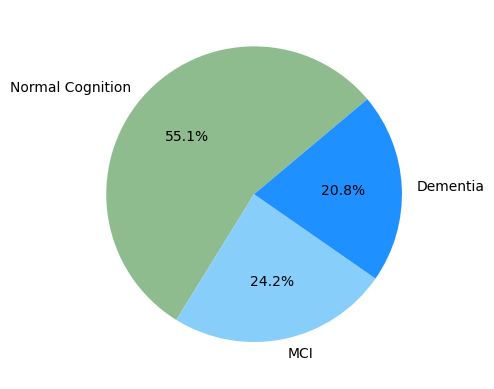

In [20]:
 # visualize class distribution
plot_class_bal(df)

In [108]:
#df.shape #(4173, 1030)
#df.head() # can't run feat transform yet bc of the added date and MRI cols

# Merge in Imaging Data
## First compare distributions between the 2 imaging datasets

In [26]:
#non_SCAN subset

#create date for merge
create_date_col(non_SCAN)

#summary mri measures available y/n y=1
non_SCAN = non_SCAN[non_SCAN['NACCMVOL'] == 1]

# define list to subset
non_SCAN_select = ['NACCID','DATE','CEREALL','GRAYVOL','HIPPOVOL','LHIPPO','RHIPPO','WMHVOL','RENTM','LENTM']

# reassign
non_SCAN = non_SCAN.loc[:,non_SCAN_select]

#SCAN subset

# define list to subset
SCAN_select = ['NACCID','SCANDT','CEREBRUMTCV','GM','HIPPOCAMPUS','LEFT_HIPPO','RIGHT_HIPPO','WMH','RH_ENTORHINAL_AVGTH','LH_ENTORHINAL_AVGTH']

# reassign
SCAN = SCAN.loc[:,SCAN_select]


In [27]:
# non_SCAN has missing codes: replace with na
missing_codes_non_SCAN = [88.8888,99.9999,8888.88,9999.99,888.8888,999.9999,9999.9999]

for col in cols_with_na:
    replace_with_na(non_SCAN, col, missing_codes_non_SCAN)

NameError: name 'cols_with_na' is not defined

In [100]:
# rename cols to compare easier
SCAN.columns = list(SCAN.columns[:2]) + list(non_SCAN.columns[2:])

## Plots: only keep those with similar distributions

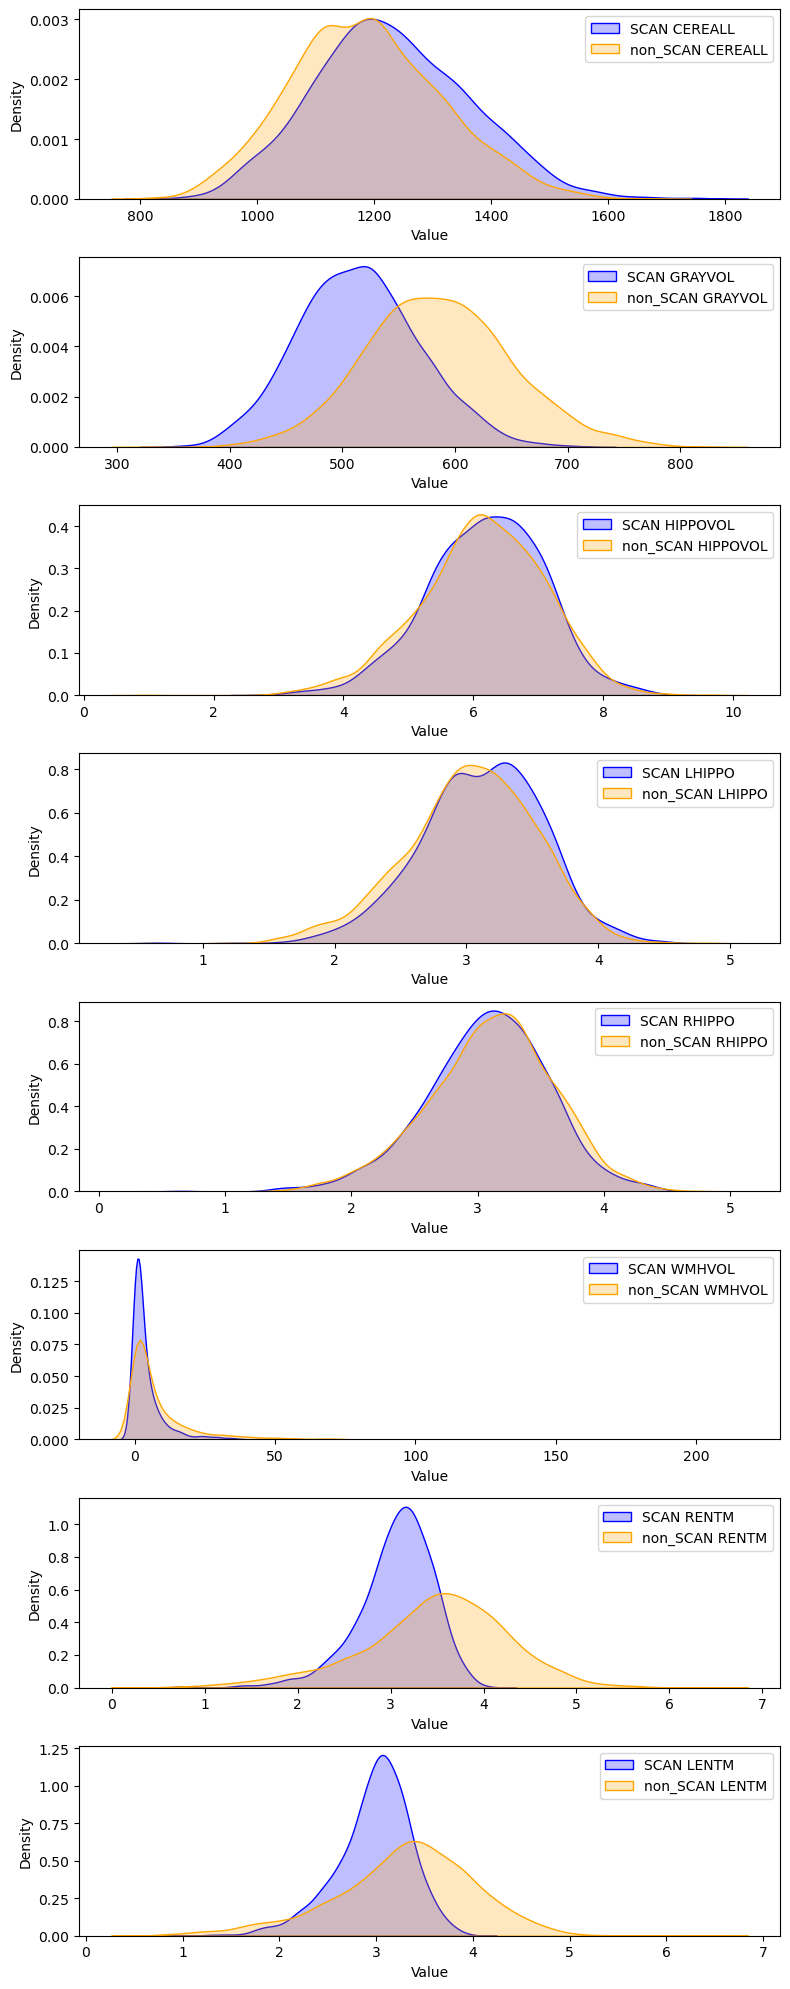

In [101]:
# List of columns to plot
columns = SCAN.columns[2:]

# Define subplots
fig, axes = plt.subplots(len(columns), 1, figsize=(8, 20))  # Adjust height based on the number of columns

# Loop through each column
for i, col in enumerate(columns):
    sns.kdeplot(SCAN[col], label=f"SCAN {col}", color="blue", fill=True, ax=axes[i])
    sns.kdeplot(non_SCAN[col], label=f"non_SCAN {col}", color="orange", fill=True, ax=axes[i])
    
    # Add titles and labels for each subplot
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Merge

In [102]:
# combine imaging data

# drop cols that dont have same distribution
cols_different_dist = ['GRAYVOL','WMHVOL','RENTM','LENTM']

for df in [SCAN, non_SCAN]:
    df = df.drop(cols_different_dist, axis=1, inplace=True)

# same naming conventions
SCAN.rename(columns={'SCANDT': 'DATE'}, inplace=True)

# data type
SCAN['DATE'] = pd.to_datetime(SCAN['DATE'])

# concat SCAN and non_SCAN datasets
imaging_data = pd.concat([SCAN,non_SCAN], axis=0)


In [109]:
# read in selected NACC data
nacc_df = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/selected_nacc_2.csv', low_memory=False, index_col=0)


In [111]:
nacc_df.shape #(4173, 1030)
#plot_class_bal(nacc_df)

(4173, 1030)

In [112]:
#imaging_data['DATE']
nacc_df['Imaging_Date'] = pd.to_datetime(nacc_df['Imaging_Date'])
nacc_df['Imaging_Date']

0      2020-11-03
1      2009-09-23
2      2024-02-20
3      2009-08-03
4      2023-01-25
          ...    
4168   2008-03-06
4169   2014-04-02
4170   2010-07-13
4171   2006-07-03
4172   2007-09-28
Name: Imaging_Date, Length: 4173, dtype: datetime64[ns]

In [113]:
# merge
all_df = imaging_data.merge(nacc_df, how='inner', left_on=['NACCID', 'DATE'], right_on=['NACCID', 'Imaging_Date'])
all_df

# check maximum days between imaging and NACC visit
all_df['Delta'].max() #99 days.. not bad

# turns into a somewhat small datset once i add the available imaging data: 3766 rows × 823 columns

'99 days'

In [122]:
all_df.shape #(4173, 1035)


(4173, 1035)

In [119]:
# Add imaging cols to the end so as not to disturb indexing in feat transform function
cols_to_add = ['CEREALL', 'HIPPOVOL', 'LHIPPO', 'RHIPPO']
cols_to_add_df = pd.DataFrame(columns=cols_to_add)

Select_Columns_w_Imaging = pd.concat([Select_Columns, cols_to_add_df], axis=1)

# add 'Class' to select_Columns_w_imaging
Select_Columns_w_Imaging["Class"] = np.nan

In [126]:
# export to csv
Select_Columns_w_Imaging.to_csv('/Users/sarahbinder/Desktop/NACC Data/Columns/Select_Columns_w_Imaging.csv')

# read in next time
#Select_Columns_w_Imaging = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/Columns/Select_Columns_w_Imaging.csv',index_col=0)

In [128]:
# select only cols in Select Columns w Imaging DF

# select columns in nacc_first that are present in select columns df
df2 = all_df[Select_Columns_w_Imaging.columns]


In [129]:
# now, feat transform
df2 = feature_transform(df2)
df2 = df2.copy()  # This creates a defragmented copy
df2 = df2.reset_index(drop=True)
df2

,BIRTHYR,SEX,HISPANIC,RACE,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,...,CEREALL,HIPPOVOL,LHIPPO,RHIPPO,Class,faq_tot,chronic_cond,cvd_cond,neuro_injury,psych_cond
0,1948,1,0.0,1.0,1.0,20.0,1.0,2.0,2.0,1.0,...,1321.39,5.662,2.800,2.862,2,2.0,1,0,0,0
1,1965,1,0.0,2.0,1.0,16.0,1.0,2.0,1.0,1.0,...,1240.05,4.525,2.488,2.037,2,13.0,1,0,0,0
2,1965,2,0.0,1.0,1.0,16.0,1.0,2.0,1.0,1.0,...,1252.65,5.433,2.801,2.632,1,0.0,1,0,0,0
3,1961,2,0.0,1.0,1.0,13.0,1.0,2.0,1.0,1.0,...,1155.95,6.113,2.873,3.240,0,0.0,1,0,1,1
4,1945,1,0.0,1.0,1.0,18.0,1.0,2.0,2.0,1.0,...,1430.81,5.871,2.908,2.963,1,12.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4168,1937,2,0.0,1.0,1.0,18.0,1.0,2.0,1.0,1.0,...,1143.39,5.400,2.860,2.540,0,0.0,0,0,0,0
4169,1941,2,0.0,1.0,1.0,18.0,3.0,1.0,1.0,1.0,...,1162.19,6.020,3.150,2.870,0,0.0,0,1,1,0
4170,1922,1,0.0,1.0,1.0,16.0,2.0,1.0,1.0,1.0,...,1140.96,5.000,2.910,2.090,0,0.0,1,0,0,0
4171,1939,2,0.0,1.0,1.0,16.0,4.0,3.0,1.0,1.0,...,1228.10,6.030,2.970,3.070,0,0.0,1,0,0,0


In [131]:
# export for a cleaned dataset next time
df2.to_csv('/Users/sarahbinder/Desktop/NACC Data/Model2_cleaned.csv')

# Read in cleaned data

In [21]:
df2 = pd.read_csv('/Users/sarahbinder/Desktop/NACC Data/Model2_cleaned.csv', low_memory=False, index_col=0)

In [22]:
df2.columns

Index(['BIRTHYR', 'SEX', 'HISPANIC', 'RACE', 'PRIMLANG', 'EDUC', 'MARISTAT',
       'NACCLIVS', 'INDEPEND', 'RESIDENC',
       ...
       'CEREALL', 'HIPPOVOL', 'LHIPPO', 'RHIPPO', 'Class', 'faq_tot',
       'chronic_cond', 'cvd_cond', 'neuro_injury', 'psych_cond'],
      dtype='object', length=275)

# Stratified K-Folds: DT & RF

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Define inputs (features) vs. output (class label)
X = df2.drop('Class', axis=1) 
y = df2['Class']  

# Set up Stratified K-Fold splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=222)

# Initialize fold counter
fold = 1

# Initialize dict to save output
folds_dict = {}

# Define classifiers 
classifiers = {
    'Decision Tree NACC & Imaging K-Folds Avg': DecisionTreeClassifier(random_state=222),
    'Random Forest NACC & Imaging K-Folds Avg': RandomForestClassifier(n_estimators=20, max_features=40, random_state=222)  
}

# Loop through each classifier
for model_name, clf in classifiers.items():
    
    # init fold counter
    fold = 1
    
    # Loop through folds
    for train_idx, val_idx in skf.split(X, y):
        # Split data per fold
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # fit
        clf.fit(X_train, y_train)

        # eval
        metrics_dict = evaluate(clf, X_test=X_val, y_test=y_val)
        folds_dict[f'Fold {fold}:'] = metrics_dict
        fold += 1

    # Calculate average metrics across all folds
    average_metrics = {
        metric: round(np.mean([fold_metrics[metric] for fold_metrics in folds_dict.values()]), 3)
        for metric in folds_dict['Fold 1:']  # Use any fold to get the metric names
    }
    
    # Add averaged metrics to results_dict
    results_dict[model_name] = average_metrics


In [24]:
results_dict

{'Decision Tree NACC': {'A': 0.813,
  'auc': 0.862,
  'F': 0.814,
  'P': 0.814,
  'R': 0.813},
 'Random Forest NACC: 5 trees': {'A': 0.844,
  'auc': 0.943,
  'F': 0.844,
  'P': 0.844,
  'R': 0.844},
 'Random Forest NACC: 10 trees': {'A': 0.857,
  'auc': 0.956,
  'F': 0.856,
  'P': 0.857,
  'R': 0.857},
 'Random Forest NACC: 20 trees': {'A': 0.861,
  'auc': 0.963,
  'F': 0.861,
  'P': 0.861,
  'R': 0.861},
 'Random Forest NACC: 5 features': {'A': 0.842,
  'auc': 0.949,
  'F': 0.841,
  'P': 0.841,
  'R': 0.842},
 'Random Forest NACC: 10 features': {'A': 0.852,
  'auc': 0.953,
  'F': 0.851,
  'P': 0.852,
  'R': 0.852},
 'Random Forest NACC: 40 features': {'A': 0.86,
  'auc': 0.958,
  'F': 0.86,
  'P': 0.86,
  'R': 0.86},
 'Decision Tree NACC & Imaging K-Folds Avg': {'A': 0.82,
  'auc': 0.859,
  'F': 0.82,
  'P': 0.822,
  'R': 0.82},
 'Random Forest NACC & Imaging K-Folds Avg': {'A': 0.871,
  'auc': 0.964,
  'F': 0.87,
  'P': 0.869,
  'R': 0.871}}

# Stratified K-Folds & Random Forest

# Assemble to DF

In [ ]:
# important features

In [ ]:
# Next Steps:
# 1. do one with just SCAN or non_SCAN dataset and NACC data: K-fold X-Val
# 2. do one with only imaging data: K-fold X-Val
# 3. Try imaging data but kNN clustering or kNN classifier: requires z-score normalization

# Model 3: Just imaging data

## Preprocessing

In [34]:
nacc_slice = nacc.loc[:,['NACCID','VISITMO', 'VISITDAY', 'VISITYR', 'NORMCOG', 'DEMENTED']]


,NACCID,VISITMO,VISITDAY,VISITYR,NORMCOG,DEMENTED
0,NACC002909,12,28,2022,0,0
1,NACC002909,1,23,2024,0,0
2,NACC003487,11,15,2023,1,0
3,NACC004352,10,5,2021,0,1
4,NACC004687,11,14,2022,1,0
...,...,...,...,...,...,...
192083,NACC998475,11,15,2007,0,0
192084,NACC998475,11,6,2008,0,1
192085,NACC999391,3,2,2006,0,0
192086,NACC999391,5,17,2007,0,1


In [37]:
create_class(nacc_slice)
create_date_col(nacc_slice)

,NACCID,VISITMO,VISITDAY,VISITYR,NORMCOG,DEMENTED,Class,DATE
0,NACC002909,12,28,2022,0,0,1,2022-12-28
1,NACC002909,1,23,2024,0,0,1,2024-01-23
2,NACC003487,11,15,2023,1,0,0,2023-11-15
3,NACC004352,10,5,2021,0,1,2,2021-10-05
4,NACC004687,11,14,2022,1,0,0,2022-11-14
...,...,...,...,...,...,...,...,...
192083,NACC998475,11,15,2007,0,0,1,2007-11-15
192084,NACC998475,11,6,2008,0,1,2,2008-11-06
192085,NACC999391,3,2,2006,0,0,1,2006-03-02
192086,NACC999391,5,17,2007,0,1,2,2007-05-17


In [100]:
# merge
merged_data = nacc_slice.merge(SCAN, how='left', on='NACCID')

In [101]:
# create delta col: for choosing smallest interval between dates
def create_delta_col_v2(df, datecolumn):
    # dynamically name column
    new_col_name = f'delta_{datecolumn}'

    # filter to not NA
    non_na = df[datecolumn].notna()

    # calc abs value of delta
    df[new_col_name] = abs(df.loc[non_na, 'DATE'] - df.loc[non_na, datecolumn]) # NACC date - scan date
    
    return df

# ensure datetime type
merged_data['SCANDT'] = pd.to_datetime(merged_data['SCANDT'])

# create delta col
merged_data = create_delta_col_v2(merged_data, 'SCANDT')

# remove NA rows
merged_notna = merged_data[merged_data['delta_SCANDT'].notna()]

# sort by delta, group by NACCID, to choose row per ID with the smallest delta
notna_sorted = merged_notna.sort_values(['NACCID', 'delta_SCANDT']).reset_index(drop=True)
selected_SCAN = notna_sorted.groupby('NACCID', as_index=False).first()


In [102]:
# Filter out rows where there's more than 2.5 years btwn diagnosis and scan date 

# convert to days
selected_SCAN['delta_SCANDT_days'] = selected_SCAN['delta_SCANDT'].dt.days

#count
selected_SCAN[selected_SCAN['delta_SCANDT_days'] > 900] # 12 rows

# Filter out
selected_SCAN = selected_SCAN[selected_SCAN['delta_SCANDT_days'] <= 900]


,NACCID,VISITMO,VISITDAY,VISITYR,NORMCOG,DEMENTED,Class,DATE,SCANDT,DESCRIPTION_T1,...,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH,NACCADC,delta_SCANDT,delta_SCANDT_days
37,NACC018613,10,3,2018,0,1,2,2018-10-03,2021-08-19,Accelerated Sagittal MPRAGE,...,2.266,5251.0,5229.0,1891.0,1932.0,2.635,2.587,2096.0,1051 days,1051
145,NACC092701,5,14,2020,1,0,0,2020-05-14,2023-10-19,MPRAGE_GRAPPA2 3D dist cor,...,2.292,4666.0,4540.0,1703.0,1630.0,2.667,2.774,1018.0,1253 days,1253
272,NACC179241,4,17,2019,0,1,2,2019-04-17,2022-05-16,Accelerated Sagittal MPRAGE,...,2.556,5838.0,6043.0,1825.0,1765.0,3.040,2.939,2096.0,1125 days,1125
343,NACC223173,4,3,2020,0,0,1,2020-04-03,2023-07-12,MPRAGE_GRAPPA2 3D dist cor,...,2.335,5836.0,5657.0,2050.0,1932.0,2.702,2.907,1018.0,1195 days,1195
346,NACC224663,9,18,2020,1,0,0,2020-09-18,2023-09-06,MPRAGE_GRAPPA2 3D dist cor,...,2.284,5990.0,5959.0,2215.0,2211.0,2.604,2.591,1018.0,1083 days,1083
468,NACC300354,9,14,2017,1,0,0,2017-09-14,2022-07-07,Accelerated_Sagittal_MPRAGE_MSV21_nc,...,2.404,5592.0,5719.0,1916.0,1948.0,2.856,2.872,4935.0,1757 days,1757
497,NACC320888,2,11,2019,0,1,2,2019-02-11,2021-08-11,Accelerated Sagittal MPRAGE,...,2.364,2399.0,3779.0,1074.0,1668.0,2.312,2.087,2096.0,912 days,912
731,NACC475686,10,7,2009,0,1,2,2009-10-07,2022-07-28,Accelerated Sagittal IR-FSPGR (MSV21),...,2.401,4970.0,4758.0,1523.0,1633.0,2.949,2.913,2289.0,4677 days,4677
823,NACC538808,4,2,2020,0,0,1,2020-04-02,2023-06-02,MPRAGE_GRAPPA2 3D dist cor,...,2.164,5547.0,5574.0,2003.0,1945.0,2.601,2.606,1018.0,1156 days,1156
1021,NACC672676,12,6,2017,0,1,2,2017-12-06,2021-05-19,Accelerated Sagittal MPRAGE,...,2.182,5262.0,5720.0,1779.0,2090.0,2.786,2.658,2096.0,1260 days,1260


In [104]:
# remove description/ID cols
cols_list = ['NACCID', 'NACCADC', 'SCANDT', 'delta_SCANDT', 'delta_SCANDT_days', 'LONI_IMAGE_FLAIR', 'DESCRIPTION_FLAIR', 'LONI_IMAGE_T1', 'DESCRIPTION_T1', 'FREESURFER_VERSION']
nacc_added_cols = ['VISITMO','VISITDAY','VISITYR','NORMCOG','DEMENTED','DATE']

cols_drop = cols_list + nacc_added_cols

selected_SCAN.drop(cols_drop, axis=1, inplace=True)


In [105]:
scan = selected_SCAN # 1438 rows × 193 columns

## Models

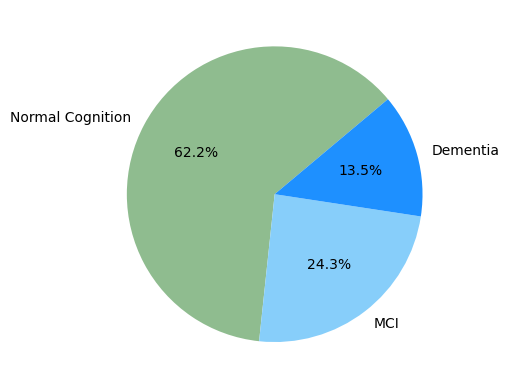

In [106]:
plot_class_bal(scan)

In [111]:
# drop rows with na 10 rows
scan.dropna(inplace=True)

scan['Class'].value_counts()

Class
0    895
1    351
2    194
Name: count, dtype: int64

# Split

In [124]:
# 1) split data into train and test, inputs and output

import numpy as np
from sklearn.model_selection import train_test_split

X = scan.drop('Class', axis=1) # drop class
y = scan['Class']  # select class (target) variable only

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=303, stratify=y, )


# SMOTE

In [117]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE
smote = SMOTE(random_state=303) 

# fit SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


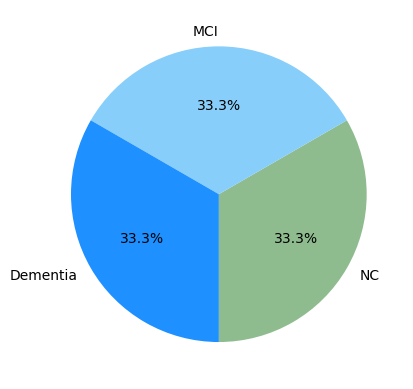

In [119]:

# count 0s and 1s in Label column
label_count = y_train_smote.value_counts()

# define parameters
labels = ['NC', 'MCI', 'Dementia']
sizes = [label_count[0], label_count[1], label_count[2]]

# assemble piechart
plt.pie(sizes, labels=labels, startangle=270,colors=['darkseagreen', 'lightskyblue', 'dodgerblue'], autopct='%1.1f%%')
plt.show()

In [120]:
y_train_smote.value_counts()

Class
1    590
2    590
0    590
Name: count, dtype: int64

# K-folds & RF 

In [126]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Set up K-Fold 
kf = KFold(n_splits=5, shuffle=True, random_state=202)

# Initialize fold counter
fold = 1

# Initialize dictionary to store results
folds_dict = {}

# Perform k-fold cross-validation
for train_idx, val_idx in kf.split(X_train_smote, y_train_smote):
    # Split data per fold
    X_train = X_train_smote.loc[train_idx]
    y_train = y_train_smote.loc[train_idx]
    X_val = X_train_smote.loc[val_idx]
    y_val = y_train_smote.loc[val_idx]

    # Fit Random Forest classifier on training data
    clf = RandomForestClassifier(n_estimators=20, max_features=40, random_state=202) 
    clf.fit(X_train, y_train) 

    # Evaluate model on validation data
    metrics_dict = evaluate(clf, X_test=X_val, y_test=y_val)  
    folds_dict[f'Fold {fold}:'] = metrics_dict
    fold += 1

# Calculate average metrics
average_metrics = {
    metric: round(np.mean([fold_metrics[metric] for fold_metrics in folds_dict.values()]), 3)
    for metric in folds_dict['Fold 1:'] 
}

# Add to results dictionary
model_name = 'SCAN 5-Fold RF'
results_dict[model_name] = average_metrics


In [127]:
#del results_dict['SCAN 5-Fold RF'] 
results_dict

{'Decision Tree NACC': {'A': 0.813,
  'auc': 0.862,
  'F': 0.814,
  'P': 0.814,
  'R': 0.813},
 'Random Forest NACC: 5 trees': {'A': 0.844,
  'auc': 0.943,
  'F': 0.844,
  'P': 0.844,
  'R': 0.844},
 'Random Forest NACC: 10 trees': {'A': 0.857,
  'auc': 0.956,
  'F': 0.856,
  'P': 0.857,
  'R': 0.857},
 'Random Forest NACC: 20 trees': {'A': 0.861,
  'auc': 0.963,
  'F': 0.861,
  'P': 0.861,
  'R': 0.861},
 'Random Forest NACC: 5 features': {'A': 0.842,
  'auc': 0.949,
  'F': 0.841,
  'P': 0.841,
  'R': 0.842},
 'Random Forest NACC: 10 features': {'A': 0.852,
  'auc': 0.953,
  'F': 0.851,
  'P': 0.852,
  'R': 0.852},
 'Random Forest NACC: 40 features': {'A': 0.86,
  'auc': 0.958,
  'F': 0.86,
  'P': 0.86,
  'R': 0.86},
 'Decision Tree NACC & Imaging K-Folds Avg': {'A': 0.82,
  'auc': 0.859,
  'F': 0.82,
  'P': 0.822,
  'R': 0.82},
 'Random Forest NACC & Imaging K-Folds Avg': {'A': 0.871,
  'auc': 0.964,
  'F': 0.87,
  'P': 0.869,
  'R': 0.871},
 'SCAN 5-Fold RF': {'A': 0.839,
  'auc': 0

# Assemble to DF


In [128]:
# convert dictionary to Dataframe
final_df = pd.DataFrame.from_dict(results_dict, orient='index') # orient=index ensures keys (model names) are rows # model_name is index

# rename columns
final_df.columns = ['Accuracy', 'AUC', 'F-measure', 'Precision', 'Recall']

# view
final_df

,Accuracy,AUC,F-measure,Precision,Recall
Decision Tree NACC,0.813,0.862,0.814,0.814,0.813
Random Forest NACC: 5 trees,0.844,0.943,0.844,0.844,0.844
Random Forest NACC: 10 trees,0.857,0.956,0.856,0.857,0.857
Random Forest NACC: 20 trees,0.861,0.963,0.861,0.861,0.861
Random Forest NACC: 5 features,0.842,0.949,0.841,0.841,0.842
Random Forest NACC: 10 features,0.852,0.953,0.851,0.852,0.852
Random Forest NACC: 40 features,0.860,0.958,0.860,0.860,0.860
Decision Tree NACC & Imaging K-Folds Avg,0.820,0.859,0.820,0.822,0.820
Random Forest NACC & Imaging K-Folds Avg,0.871,0.964,0.870,0.869,0.871
SCAN 5-Fold RF,0.839,0.943,0.839,0.840,0.839


In [ ]:
from sklearn import tree

plt.figure(figsize=(12,18))
tree.plot_tree(clf, class_names=['normal','MCI','dementia'], filled=True) # filled= True colors nodes by class 
plt.show()

In [129]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

# Method 1: Mutual Info Class

# initialize
feat_select = SelectKBest(score_func=mutual_info_classif, k=5) # mutual_info_class function is better for binary class and imbalanced data

# fit
feat_select.fit(X_train_smote, y_train_smote)

# Return top 5 feature names
feat_select.get_feature_names_out()


array(['LH_ENTORHINAL_AVGTH', 'RH_INFERIORTEMPORAL_AVGTH',
       'LH_MIDDLETEMPORAL_AVGTH', 'RH_MIDDLETEMPORAL_AVGTH',
       'LH_PRECUNEUS_AVGTH'], dtype=object)

In [130]:
# Method 2: Chi-Squared

# initialize
feat_select = SelectKBest(score_func=chi2, k=5) # mutual_info_class function is better for binary class and imbalanced data

# fit
feat_select.fit(X_train_smote, y_train_smote)

# Return top 5 feature names
feat_select.get_feature_names_out()

array(['LH_INFERIORPARIETAL_GVOL', 'RH_INFERIORPARIETAL_GVOL',
       'LH_INFERIORTEMPORAL_GVOL', 'LH_MIDDLETEMPORAL_GVOL',
       'RH_MIDDLETEMPORAL_GVOL'], dtype=object)

# kNN Classifier

# standard scalar

In [133]:
def normalize(df, norm_type='ss', percentiles =(5,95)): # default is ss
    
    # define norm_df
    norm_df = df.copy()
    
    # iterate over columns
    for col in df.columns:
        
        # standard scalar
        if norm_type == 'ss':
            mean = df[col].mean()
            sd = df[col].std()
            norm_df[col] = (df[col] - mean)/sd
        
        # minmax scalar
        elif norm_type == 'minmax':
            min_val = df[col].min()
            max_val = df[col].max()
            norm_df[col] = (df[col] - min_val) / (max_val - min_val)
        
        #percentile scalar
        elif norm_type == 'percentile':
            lower_p, upper_p = np.percentile(df[col], percentiles)
            norm_df[col] = (df[col] - lower_p) / (upper_p - lower_p)
        
    return norm_df

In [135]:
# normalize
X_train_norm = normalize(X_train)

# redo SMOTE
# initialize SMOTE
smote = SMOTE(random_state=303) 

# fit SMOTE to training data
X_train_smote_n, y_train_smote_n = smote.fit_resample(X_train_norm, y_train)


In [148]:
# adapt
# this is the one

from sklearn.neighbors import KNeighborsClassifier 

# Set up K-Fold 
kf = KFold(n_splits=5, shuffle=True, random_state=202)

# Initialize fold counter
fold = 1

# Initialize dictionary to store results
folds_dict = {}

# Perform k-fold cross-validation
for train_idx, val_idx in kf.split(X_train_smote_n, y_train_smote_n):
    # Split data per fold
    X_train = X_train_smote.loc[train_idx]
    y_train = y_train_smote.loc[train_idx]
    X_val = X_train_smote.loc[val_idx]
    y_val = y_train_smote.loc[val_idx]

    model = KNeighborsClassifier(n_neighbors=2)# init
    model.fit(X_train, y_train) # fit

    # Evaluate model on validation data
    metrics_dict = evaluate(model, X_test=X_val, y_test=y_val)  
    folds_dict[f'Fold {fold}:'] = metrics_dict
    fold += 1

# Calculate average metrics
average_metrics = {
    metric: round(np.mean([fold_metrics[metric] for fold_metrics in folds_dict.values()]), 3)
    for metric in folds_dict['Fold 1:'] 
}

# Add to results dictionary
model_name = 'SCAN 5-Fold kNN 2'
results_dict[model_name] = average_metrics


In [149]:
results_dict

{'Decision Tree NACC': {'A': 0.813,
  'auc': 0.862,
  'F': 0.814,
  'P': 0.814,
  'R': 0.813},
 'Random Forest NACC: 5 trees': {'A': 0.844,
  'auc': 0.943,
  'F': 0.844,
  'P': 0.844,
  'R': 0.844},
 'Random Forest NACC: 10 trees': {'A': 0.857,
  'auc': 0.956,
  'F': 0.856,
  'P': 0.857,
  'R': 0.857},
 'Random Forest NACC: 20 trees': {'A': 0.861,
  'auc': 0.963,
  'F': 0.861,
  'P': 0.861,
  'R': 0.861},
 'Random Forest NACC: 5 features': {'A': 0.842,
  'auc': 0.949,
  'F': 0.841,
  'P': 0.841,
  'R': 0.842},
 'Random Forest NACC: 10 features': {'A': 0.852,
  'auc': 0.953,
  'F': 0.851,
  'P': 0.852,
  'R': 0.852},
 'Random Forest NACC: 40 features': {'A': 0.86,
  'auc': 0.958,
  'F': 0.86,
  'P': 0.86,
  'R': 0.86},
 'Decision Tree NACC & Imaging K-Folds Avg': {'A': 0.82,
  'auc': 0.859,
  'F': 0.82,
  'P': 0.822,
  'R': 0.82},
 'Random Forest NACC & Imaging K-Folds Avg': {'A': 0.871,
  'auc': 0.964,
  'F': 0.87,
  'P': 0.869,
  'R': 0.871},
 'SCAN 5-Fold RF': {'A': 0.839,
  'auc': 0

In [150]:
my_results = results_dict.copy()

del my_results['SCAN 5-Fold kNN 5']
del my_results['SCAN 5-Fold kNN 20']
del my_results['SCAN 5-Fold kNN 100']
del my_results['SCAN 5-Fold kNN 3']

my_results 

{'Decision Tree NACC': {'A': 0.813,
  'auc': 0.862,
  'F': 0.814,
  'P': 0.814,
  'R': 0.813},
 'Random Forest NACC: 5 trees': {'A': 0.844,
  'auc': 0.943,
  'F': 0.844,
  'P': 0.844,
  'R': 0.844},
 'Random Forest NACC: 10 trees': {'A': 0.857,
  'auc': 0.956,
  'F': 0.856,
  'P': 0.857,
  'R': 0.857},
 'Random Forest NACC: 20 trees': {'A': 0.861,
  'auc': 0.963,
  'F': 0.861,
  'P': 0.861,
  'R': 0.861},
 'Random Forest NACC: 5 features': {'A': 0.842,
  'auc': 0.949,
  'F': 0.841,
  'P': 0.841,
  'R': 0.842},
 'Random Forest NACC: 10 features': {'A': 0.852,
  'auc': 0.953,
  'F': 0.851,
  'P': 0.852,
  'R': 0.852},
 'Random Forest NACC: 40 features': {'A': 0.86,
  'auc': 0.958,
  'F': 0.86,
  'P': 0.86,
  'R': 0.86},
 'Decision Tree NACC & Imaging K-Folds Avg': {'A': 0.82,
  'auc': 0.859,
  'F': 0.82,
  'P': 0.822,
  'R': 0.82},
 'Random Forest NACC & Imaging K-Folds Avg': {'A': 0.871,
  'auc': 0.964,
  'F': 0.87,
  'P': 0.869,
  'R': 0.871},
 'SCAN 5-Fold RF': {'A': 0.839,
  'auc': 0

In [151]:
# rename keys for clarity
my_results['Random Forest SCAN 5-Fold SMOTE'] = my_results.pop('SCAN 5-Fold RF')
my_results['kNN SCAN 5-Fold SMOTE k=10'] = my_results.pop('SCAN 5-Fold kNN')
my_results['kNN SCAN 5-Fold SMOTE k=2'] = my_results.pop('SCAN 5-Fold kNN 2')

# Results

In [152]:
# convert dictionary to Dataframe
final_df_2 = pd.DataFrame.from_dict(my_results , orient='index') # orient=index ensures keys (model names) are rows # model_name is index

# rename columns
final_df_2.columns = ['Accuracy', 'AUC', 'F-measure', 'Precision', 'Recall']

# view
final_df_2

,Accuracy,AUC,F-measure,Precision,Recall
Decision Tree NACC,0.813,0.862,0.814,0.814,0.813
Random Forest NACC: 5 trees,0.844,0.943,0.844,0.844,0.844
Random Forest NACC: 10 trees,0.857,0.956,0.856,0.857,0.857
Random Forest NACC: 20 trees,0.861,0.963,0.861,0.861,0.861
Random Forest NACC: 5 features,0.842,0.949,0.841,0.841,0.842
Random Forest NACC: 10 features,0.852,0.953,0.851,0.852,0.852
Random Forest NACC: 40 features,0.860,0.958,0.860,0.860,0.860
Decision Tree NACC & Imaging K-Folds Avg,0.820,0.859,0.820,0.822,0.820
Random Forest NACC & Imaging K-Folds Avg,0.871,0.964,0.870,0.869,0.871
Random Forest SCAN 5-Fold SMOTE,0.839,0.943,0.839,0.840,0.839
